Для переобучения выбрал 2 стратегии:
1. Модель должна быть достаточно сложна для описания данных, чтобы суметь "запомнить" весь датасет - добавил 2 доп слоя с relu
2. Существенно ограничил количество данных, чтобы были заметны отличия train от valid - train 5000 примеров, valid 1000

В итоге на графиках (особенно лосса) заметно, что примерно после 15 эпохи сеть начинает потихоньку переобучаться, теряя качество предсказаний на valid

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, fashion_mnist, plot_graphs
import numpy as np

In [2]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=1000)

In [3]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
#         self.fc_odd1 = nn.Linear(128, 64)
#         self.fc_odd2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
#         x = F.relu(self.fc_odd1(x))
#         x = F.relu(self.fc_odd2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [5]:
# models = {'default': Net(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
models = {'fast': Net(False, False, 1e-3, 0.0), 'best_lr': Net(False, False, 3e-4, 0.0), 'decay': Net(False, False, 1e-4, 1e-5), 'mixed': Net(False, False, 3e-4, 1e-5)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [7]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)
    test(models, train_loader, train_log)

Train Epoch: 1 [0/5000 (0%)]	Losses fast: 2.285008 best_lr: 2.294628 decay: 2.300779 mixed: 2.294127
Train Epoch: 1 [5000/5000 (100%)]	Losses fast: 0.654806 best_lr: 0.925204 decay: 1.506876 mixed: 0.948687
Test set:
fast: Loss: 0.5879	Accuracy: 786.0/1000 (79%)
best_lr: Loss: 0.9030	Accuracy: 702.0/1000 (70%)
decay: Loss: 1.4644	Accuracy: 620.0/1000 (62%)
mixed: Loss: 0.9154	Accuracy: 689.0/1000 (69%)

Test set:
fast: Loss: 0.5866	Accuracy: 3893.0/5000 (78%)
best_lr: Loss: 0.9091	Accuracy: 3473.0/5000 (69%)
decay: Loss: 1.4692	Accuracy: 3083.0/5000 (62%)
mixed: Loss: 0.9187	Accuracy: 3393.0/5000 (68%)

Train Epoch: 2 [0/5000 (0%)]	Losses fast: 0.733308 best_lr: 1.037849 decay: 1.492830 mixed: 1.014486
Train Epoch: 2 [5000/5000 (100%)]	Losses fast: 0.314671 best_lr: 0.591036 decay: 1.088081 mixed: 0.610033
Test set:
fast: Loss: 0.4952	Accuracy: 830.0/1000 (83%)
best_lr: Loss: 0.6820	Accuracy: 776.0/1000 (78%)
decay: Loss: 1.0671	Accuracy: 683.0/1000 (68%)
mixed: Loss: 0.7027	Accuracy: 


Test set:
fast: Loss: 0.2061	Accuracy: 4626.0/5000 (93%)
best_lr: Loss: 0.3122	Accuracy: 4453.0/5000 (89%)
decay: Loss: 0.4513	Accuracy: 4227.0/5000 (85%)
mixed: Loss: 0.3129	Accuracy: 4455.0/5000 (89%)

Train Epoch: 15 [0/5000 (0%)]	Losses fast: 0.239946 best_lr: 0.388802 decay: 0.556273 mixed: 0.392019
Train Epoch: 15 [5000/5000 (100%)]	Losses fast: 0.163841 best_lr: 0.408821 decay: 0.476043 mixed: 0.405645
Test set:
fast: Loss: 0.4342	Accuracy: 854.0/1000 (85%)
best_lr: Loss: 0.4386	Accuracy: 841.0/1000 (84%)
decay: Loss: 0.4788	Accuracy: 835.0/1000 (84%)
mixed: Loss: 0.4336	Accuracy: 839.0/1000 (84%)

Test set:
fast: Loss: 0.1850	Accuracy: 4680.0/5000 (94%)
best_lr: Loss: 0.3078	Accuracy: 4474.0/5000 (89%)
decay: Loss: 0.4400	Accuracy: 4277.0/5000 (86%)
mixed: Loss: 0.3055	Accuracy: 4492.0/5000 (90%)

Train Epoch: 16 [0/5000 (0%)]	Losses fast: 0.205023 best_lr: 0.393630 decay: 0.540285 mixed: 0.382570
Train Epoch: 16 [5000/5000 (100%)]	Losses fast: 0.148316 best_lr: 0.231068 decay

Train Epoch: 28 [0/5000 (0%)]	Losses fast: 0.152219 best_lr: 0.229775 decay: 0.320396 mixed: 0.236407
Train Epoch: 28 [5000/5000 (100%)]	Losses fast: 0.140737 best_lr: 0.223293 decay: 0.388547 mixed: 0.251179
Test set:
fast: Loss: 0.5201	Accuracy: 859.0/1000 (86%)
best_lr: Loss: 0.4328	Accuracy: 863.0/1000 (86%)
decay: Loss: 0.4205	Accuracy: 850.0/1000 (85%)
mixed: Loss: 0.4388	Accuracy: 857.0/1000 (86%)

Test set:
fast: Loss: 0.0978	Accuracy: 4830.0/5000 (97%)
best_lr: Loss: 0.2067	Accuracy: 4651.0/5000 (93%)
decay: Loss: 0.3442	Accuracy: 4411.0/5000 (88%)
mixed: Loss: 0.2133	Accuracy: 4641.0/5000 (93%)

Train Epoch: 29 [0/5000 (0%)]	Losses fast: 0.155684 best_lr: 0.283298 decay: 0.376318 mixed: 0.294788
Train Epoch: 29 [5000/5000 (100%)]	Losses fast: 0.037565 best_lr: 0.111187 decay: 0.270730 mixed: 0.137752
Test set:
fast: Loss: 0.5199	Accuracy: 861.0/1000 (86%)
best_lr: Loss: 0.4154	Accuracy: 869.0/1000 (87%)
decay: Loss: 0.4148	Accuracy: 860.0/1000 (86%)
mixed: Loss: 0.4122	Accura


Test set:
fast: Loss: 0.0377	Accuracy: 4946.0/5000 (99%)
best_lr: Loss: 0.1391	Accuracy: 4765.0/5000 (95%)
decay: Loss: 0.2878	Accuracy: 4514.0/5000 (90%)
mixed: Loss: 0.1438	Accuracy: 4759.0/5000 (95%)

Train Epoch: 42 [0/5000 (0%)]	Losses fast: 0.104778 best_lr: 0.190817 decay: 0.263117 mixed: 0.194441
Train Epoch: 42 [5000/5000 (100%)]	Losses fast: 0.046002 best_lr: 0.106027 decay: 0.187694 mixed: 0.109788
Test set:
fast: Loss: 0.6362	Accuracy: 856.0/1000 (86%)
best_lr: Loss: 0.4831	Accuracy: 859.0/1000 (86%)
decay: Loss: 0.4177	Accuracy: 858.0/1000 (86%)
mixed: Loss: 0.4805	Accuracy: 857.0/1000 (86%)

Test set:
fast: Loss: 0.0410	Accuracy: 4934.0/5000 (99%)
best_lr: Loss: 0.1427	Accuracy: 4767.0/5000 (95%)
decay: Loss: 0.2891	Accuracy: 4507.0/5000 (90%)
mixed: Loss: 0.1438	Accuracy: 4756.0/5000 (95%)

Train Epoch: 43 [0/5000 (0%)]	Losses fast: 0.036529 best_lr: 0.161640 decay: 0.341031 mixed: 0.164402
Train Epoch: 43 [5000/5000 (100%)]	Losses fast: 0.069832 best_lr: 0.205917 decay

Train Epoch: 55 [0/5000 (0%)]	Losses fast: 0.009441 best_lr: 0.072620 decay: 0.202936 mixed: 0.090759
Train Epoch: 55 [5000/5000 (100%)]	Losses fast: 0.007571 best_lr: 0.077049 decay: 0.361827 mixed: 0.060589
Test set:
fast: Loss: 0.7057	Accuracy: 862.0/1000 (86%)
best_lr: Loss: 0.5204	Accuracy: 855.0/1000 (86%)
decay: Loss: 0.4005	Accuracy: 863.0/1000 (86%)
mixed: Loss: 0.5026	Accuracy: 863.0/1000 (86%)

Test set:
fast: Loss: 0.0097	Accuracy: 4992.0/5000 (100%)
best_lr: Loss: 0.0947	Accuracy: 4844.0/5000 (97%)
decay: Loss: 0.2404	Accuracy: 4595.0/5000 (92%)
mixed: Loss: 0.0944	Accuracy: 4848.0/5000 (97%)

Train Epoch: 56 [0/5000 (0%)]	Losses fast: 0.005802 best_lr: 0.084354 decay: 0.269076 mixed: 0.081656
Train Epoch: 56 [5000/5000 (100%)]	Losses fast: 0.019074 best_lr: 0.072962 decay: 0.218690 mixed: 0.081081
Test set:
fast: Loss: 0.7607	Accuracy: 848.0/1000 (85%)
best_lr: Loss: 0.5316	Accuracy: 854.0/1000 (85%)
decay: Loss: 0.3957	Accuracy: 865.0/1000 (86%)
mixed: Loss: 0.5249	Accur


Test set:
fast: Loss: 0.0236	Accuracy: 4958.0/5000 (99%)
best_lr: Loss: 0.0453	Accuracy: 4960.0/5000 (99%)
decay: Loss: 0.2139	Accuracy: 4631.0/5000 (93%)
mixed: Loss: 0.0511	Accuracy: 4934.0/5000 (99%)

Train Epoch: 69 [0/5000 (0%)]	Losses fast: 0.002976 best_lr: 0.041939 decay: 0.276123 mixed: 0.037672
Train Epoch: 69 [5000/5000 (100%)]	Losses fast: 0.019339 best_lr: 0.037506 decay: 0.311513 mixed: 0.026056
Test set:
fast: Loss: 0.7615	Accuracy: 857.0/1000 (86%)
best_lr: Loss: 0.5777	Accuracy: 859.0/1000 (86%)
decay: Loss: 0.4096	Accuracy: 861.0/1000 (86%)
mixed: Loss: 0.5743	Accuracy: 864.0/1000 (86%)

Test set:
fast: Loss: 0.0570	Accuracy: 4904.0/5000 (98%)
best_lr: Loss: 0.0437	Accuracy: 4946.0/5000 (99%)
decay: Loss: 0.2025	Accuracy: 4658.0/5000 (93%)
mixed: Loss: 0.0511	Accuracy: 4930.0/5000 (99%)

Train Epoch: 70 [0/5000 (0%)]	Losses fast: 0.016074 best_lr: 0.027751 decay: 0.130401 mixed: 0.049733
Train Epoch: 70 [5000/5000 (100%)]	Losses fast: 0.054108 best_lr: 0.031553 decay

Train Epoch: 82 [0/5000 (0%)]	Losses fast: 0.002274 best_lr: 0.058035 decay: 0.193580 mixed: 0.056490
Train Epoch: 82 [5000/5000 (100%)]	Losses fast: 0.001029 best_lr: 0.025892 decay: 0.165735 mixed: 0.028029
Test set:
fast: Loss: 0.8352	Accuracy: 862.0/1000 (86%)
best_lr: Loss: 0.6541	Accuracy: 859.0/1000 (86%)
decay: Loss: 0.4177	Accuracy: 866.0/1000 (87%)
mixed: Loss: 0.6267	Accuracy: 862.0/1000 (86%)

Test set:
fast: Loss: 0.0014	Accuracy: 5000.0/5000 (100%)
best_lr: Loss: 0.0287	Accuracy: 4961.0/5000 (99%)
decay: Loss: 0.1768	Accuracy: 4703.0/5000 (94%)
mixed: Loss: 0.0311	Accuracy: 4962.0/5000 (99%)

Train Epoch: 83 [0/5000 (0%)]	Losses fast: 0.001210 best_lr: 0.018657 decay: 0.222841 mixed: 0.022364
Train Epoch: 83 [5000/5000 (100%)]	Losses fast: 0.006331 best_lr: 0.067944 decay: 0.261440 mixed: 0.078325
Test set:
fast: Loss: 0.9022	Accuracy: 847.0/1000 (85%)
best_lr: Loss: 0.6841	Accuracy: 857.0/1000 (86%)
decay: Loss: 0.4171	Accuracy: 870.0/1000 (87%)
mixed: Loss: 0.6336	Accur

Train Epoch: 95 [5000/5000 (100%)]	Losses fast: 0.000777 best_lr: 0.010796 decay: 0.172804 mixed: 0.024566
Test set:
fast: Loss: 0.8322	Accuracy: 869.0/1000 (87%)
best_lr: Loss: 0.7936	Accuracy: 844.0/1000 (84%)
decay: Loss: 0.4290	Accuracy: 869.0/1000 (87%)
mixed: Loss: 0.7392	Accuracy: 857.0/1000 (86%)

Test set:
fast: Loss: 0.0009	Accuracy: 5000.0/5000 (100%)
best_lr: Loss: 0.0169	Accuracy: 4986.0/5000 (100%)
decay: Loss: 0.1480	Accuracy: 4741.0/5000 (95%)
mixed: Loss: 0.0145	Accuracy: 4988.0/5000 (100%)

Train Epoch: 96 [0/5000 (0%)]	Losses fast: 0.000824 best_lr: 0.029493 decay: 0.144884 mixed: 0.018311
Train Epoch: 96 [5000/5000 (100%)]	Losses fast: 0.001242 best_lr: 0.013531 decay: 0.148064 mixed: 0.010158
Test set:
fast: Loss: 0.8551	Accuracy: 868.0/1000 (87%)
best_lr: Loss: 0.7665	Accuracy: 845.0/1000 (84%)
decay: Loss: 0.4357	Accuracy: 864.0/1000 (86%)
mixed: Loss: 0.7361	Accuracy: 852.0/1000 (85%)

Test set:
fast: Loss: 0.0009	Accuracy: 5000.0/5000 (100%)
best_lr: Loss: 0.02

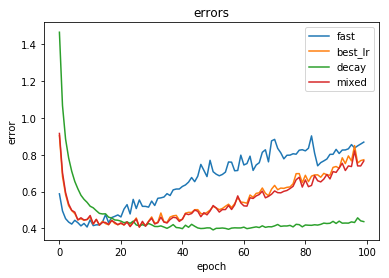

In [8]:
plot_graphs(test_log, 'loss')

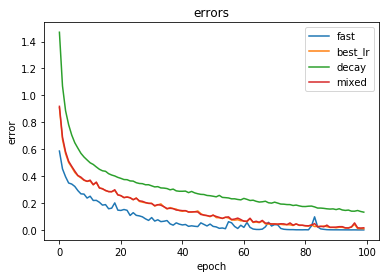

In [9]:
plot_graphs(train_log, 'loss')

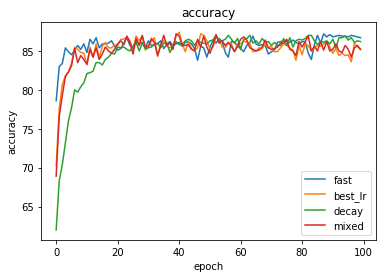

In [10]:
plot_graphs(test_log, 'accuracy')

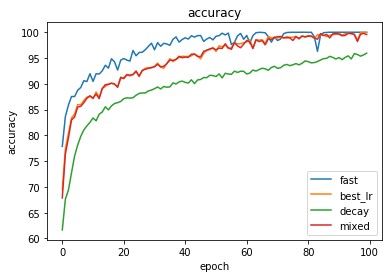

In [11]:
plot_graphs(train_log, 'accuracy')

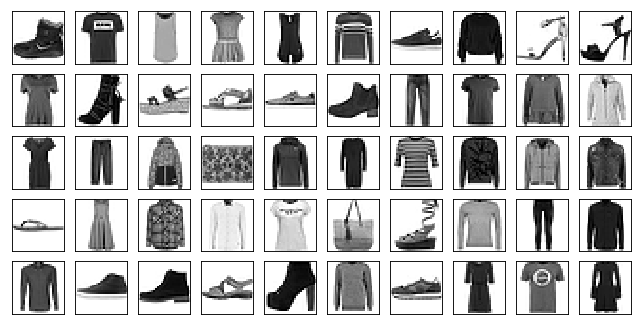

In [12]:
from utils import plot_fashion_mnist

train_data = datasets.FashionMNIST('./FashionMNIST_data', train=True, download=True, transform=transforms.ToTensor())
images = [train_data[i][0] for i in range(50)]
plot_fashion_mnist(images, (5, 10))